
# Instrument Effects & Measurement Bias in Space Physics (Undergraduate Lab)

**Focus:** How instrument and geometry effects change what you *think* you measured.  
**Inputs:** A "true" solar radial magnetic field on latitude.  
**Outputs:** Synthetic measurements with controlled bias + uncertainty metrics.

---

## What you will learn
- How **projection (line-of-sight)** changes the measured signal
- How **noise** degrades recovery of the true field
- How **limited spatial coverage** (e.g., polar gaps) biases global conclusions
- How **finite resolution** smooths small-scale structures
- How to quantify performance using **RMSE** and **correlation**



## 0) Setup


In [1]:

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

def nice_plot():
    plt.grid(True, alpha=0.25)
    plt.tight_layout()

def rmse(a, b):
    valid = np.isfinite(a) & np.isfinite(b)
    return np.sqrt(np.mean((a[valid] - b[valid])**2))

def corr(a, b):
    valid = np.isfinite(a) & np.isfinite(b)
    aa, bb = a[valid], b[valid]
    if aa.size < 3:
        return np.nan
    aa = aa - aa.mean()
    bb = bb - bb.mean()
    denom = np.sqrt(np.sum(aa**2) * np.sum(bb**2))
    return np.sum(aa*bb) / denom if denom > 0 else np.nan



## 1) Build a "truth" field: radial magnetic field Br(latitude)

We use a simple model:
- Large-scale dipole component ~ cos(theta)
- Mid-latitude activity belts represented by Gaussians with opposite polarity

This is a teaching proxy for the solar surface field.


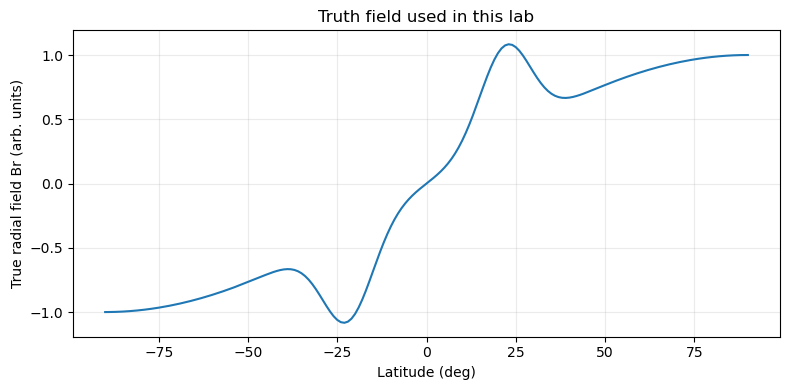

In [2]:

# Latitude grid
N_theta = 181
theta = np.linspace(0, np.pi, N_theta)           # colatitude
lat_deg = 90.0 - np.degrees(theta)               # latitude (+N ... -S)

def gauss(x, mu, sig):
    return np.exp(-(x - mu)**2/(2*sig**2))

def build_truth_field(theta, dipole_amp=1.0, belt_amp=0.7, belt_lat=20, belt_width=8):
    lat = 90.0 - np.degrees(theta)
    Br = dipole_amp * np.cos(theta)
    Br += belt_amp * (gauss(lat, +belt_lat, belt_width) - gauss(lat, -belt_lat, belt_width))
    return Br

Br_true = build_truth_field(theta, dipole_amp=1.0, belt_amp=0.7, belt_lat=22, belt_width=7)

plt.figure(figsize=(8,4))
plt.plot(lat_deg, Br_true)
plt.xlabel("Latitude (deg)")
plt.ylabel("True radial field Br (arb. units)")
plt.title("Truth field used in this lab")
nice_plot()
plt.show()



## 2) Define an "instrument": projection + resolution + noise + coverage

### Effects we model
1. **Projection (LOS):** B_LOS ≈ Br * cos(latitude)  (equatorial observer)
2. **Finite resolution:** smoothing by a Gaussian kernel (in latitude index space)
3. **Noise:** additive Gaussian noise
4. **Coverage:** missing data at high |latitude| (polar gap)

> These are simplified, but they capture the main *ideas* behind real measurement limitations.


In [3]:

def gaussian_smooth_1d(x, sigma_pix):
    """Gaussian smoothing without external libraries (sigma in pixels)."""
    if sigma_pix <= 0:
        return x.copy()
    radius = int(max(3, np.ceil(4*sigma_pix)))
    k = np.arange(-radius, radius+1)
    w = np.exp(-(k**2)/(2*sigma_pix**2))
    w /= w.sum()
    # pad edges
    xp = np.pad(x, (radius, radius), mode="edge")
    y = np.convolve(xp, w, mode="valid")
    return y

def simulate_measurement(
    Br,
    lat_deg,
    noise_sigma=0.10,
    resolution_sigma_pix=0.0,
    polar_cut_deg=75,
    observer="equatorial"
):
    """Return ideal LOS, measured LOS, and projection factor."""
    if observer == "equatorial":
        proj = np.cos(np.radians(lat_deg))     # 1 at equator, 0 at poles
    elif observer == "pole_on":
        # toy alternative: observer above north pole (not physically exact; used for teaching)
        proj = np.abs(np.sin(np.radians(lat_deg)))  # stronger toward poles
    else:
        raise ValueError("observer must be 'equatorial' or 'pole_on'")

    # Projection (LOS)
    Blos = Br * proj

    # Finite resolution (smoothing)
    Blos_res = gaussian_smooth_1d(Blos, resolution_sigma_pix)

    # Add noise
    Blos_noisy = Blos_res + rng.normal(0.0, noise_sigma, size=Br.shape)

    # Coverage mask (polar gap)
    mask = np.abs(lat_deg) >= polar_cut_deg
    Blos_noisy = Blos_noisy.copy()
    Blos_noisy[mask] = np.nan

    return Blos, Blos_noisy, proj

def naive_recover_radial(Blos_meas, proj, proj_floor=0.25):
    """Naive inversion Br ~ Blos / proj, using a floor to avoid huge blow-up."""
    proj_safe = np.maximum(proj, proj_floor)
    return Blos_meas / proj_safe



## 3) One example: see the chain (truth → LOS → measured → recovered)


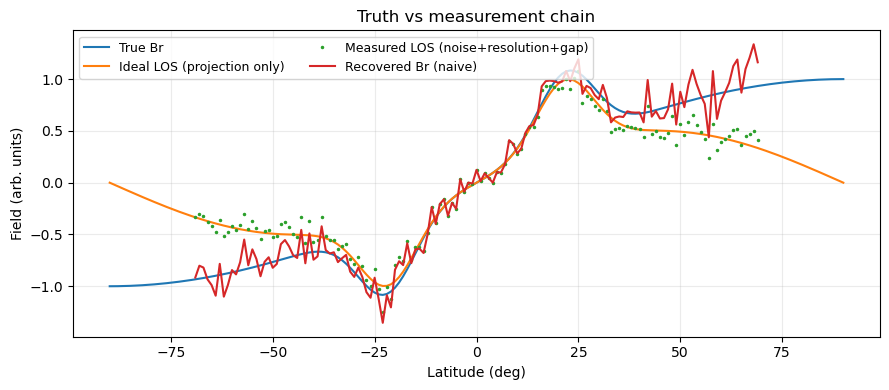

Metrics (Recovered vs True):
  RMSE = 0.12965232268708676
  Corr = 0.9863914209635702


In [4]:

Blos_ideal, Blos_meas, proj = simulate_measurement(
    Br_true, lat_deg,
    noise_sigma=0.10,
    resolution_sigma_pix=2.0,
    polar_cut_deg=70,
    observer="equatorial"
)

Br_rec = naive_recover_radial(Blos_meas, proj, proj_floor=0.25)

plt.figure(figsize=(9,4))
plt.plot(lat_deg, Br_true, label="True Br")
plt.plot(lat_deg, Blos_ideal, label="Ideal LOS (projection only)")
plt.plot(lat_deg, Blos_meas, ".", ms=3, label="Measured LOS (noise+resolution+gap)")
plt.plot(lat_deg, Br_rec, label="Recovered Br (naive)")
plt.xlabel("Latitude (deg)")
plt.ylabel("Field (arb. units)")
plt.title("Truth vs measurement chain")
plt.legend(ncol=2, fontsize=9)
nice_plot()
plt.show()

print("Metrics (Recovered vs True):")
print("  RMSE =", rmse(Br_rec, Br_true))
print("  Corr =", corr(Br_rec, Br_true))



## 4) Experiment A: Noise scan (how uncertainty grows)

You will vary noise_sigma and measure:
- RMSE (lower is better)
- Correlation (closer to 1 is better)

**Task:** Run the cell, then describe in 2 sentences what happens as noise increases.


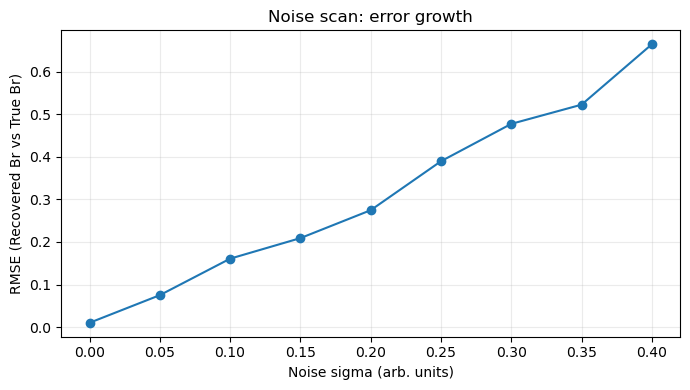

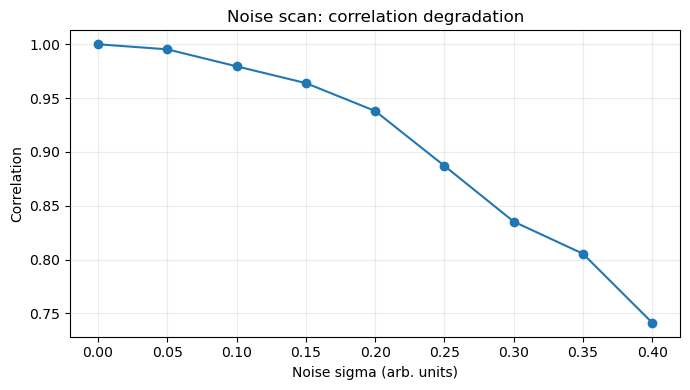

In [5]:

noise_levels = np.linspace(0.0, 0.4, 9)  # 0 to 0.4
rmse_list, corr_list = [], []

for ns in noise_levels:
    _, Blos_meas, proj = simulate_measurement(
        Br_true, lat_deg,
        noise_sigma=ns,
        resolution_sigma_pix=2.0,
        polar_cut_deg=70
    )
    Br_rec = naive_recover_radial(Blos_meas, proj, proj_floor=0.25)
    rmse_list.append(rmse(Br_rec, Br_true))
    corr_list.append(corr(Br_rec, Br_true))

plt.figure(figsize=(7,4))
plt.plot(noise_levels, rmse_list, marker="o")
plt.xlabel("Noise sigma (arb. units)")
plt.ylabel("RMSE (Recovered Br vs True Br)")
plt.title("Noise scan: error growth")
nice_plot()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(noise_levels, corr_list, marker="o")
plt.xlabel("Noise sigma (arb. units)")
plt.ylabel("Correlation")
plt.title("Noise scan: correlation degradation")
nice_plot()
plt.show()



## 5) Experiment B: Resolution scan (what does smoothing hide?)

Real instruments have **finite spatial resolution**, which acts like smoothing.
Here we scan resolution_sigma_pix (Gaussian smoothing strength).

**Task:** Identify which features disappear first as resolution worsens.


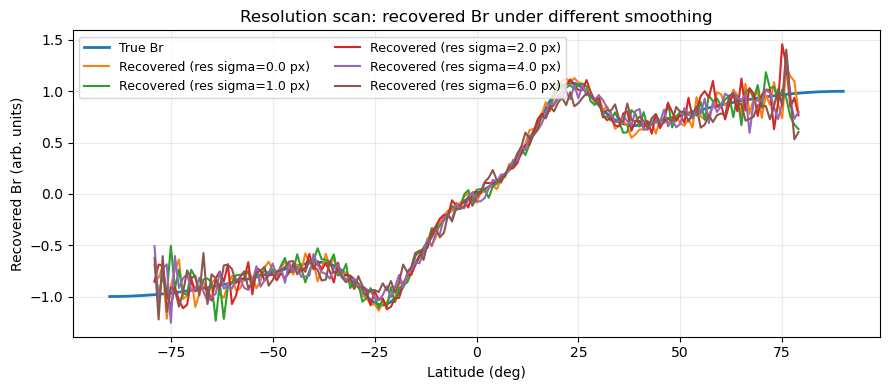

In [6]:

res_levels = [0.0, 1.0, 2.0, 4.0, 6.0]

plt.figure(figsize=(9,4))
plt.plot(lat_deg, Br_true, label="True Br", linewidth=2)

for rs in res_levels:
    _, Blos_meas, proj = simulate_measurement(
        Br_true, lat_deg,
        noise_sigma=0.05,
        resolution_sigma_pix=rs,
        polar_cut_deg=80
    )
    Br_rec = naive_recover_radial(Blos_meas, proj, proj_floor=0.25)
    plt.plot(lat_deg, Br_rec, label=f"Recovered (res sigma={rs} px)")

plt.xlabel("Latitude (deg)")
plt.ylabel("Recovered Br (arb. units)")
plt.title("Resolution scan: recovered Br under different smoothing")
plt.legend(ncol=2, fontsize=9)
nice_plot()
plt.show()



## 6) Experiment C: Polar gap scan (missing coverage → bias)

Many solar measurements are less reliable at high latitudes (poles).  
We simulate a **polar data gap** by masking |lat| ≥ polar_cut_deg.

**Task:** Explain why losing polar data can distort conclusions about the global field.


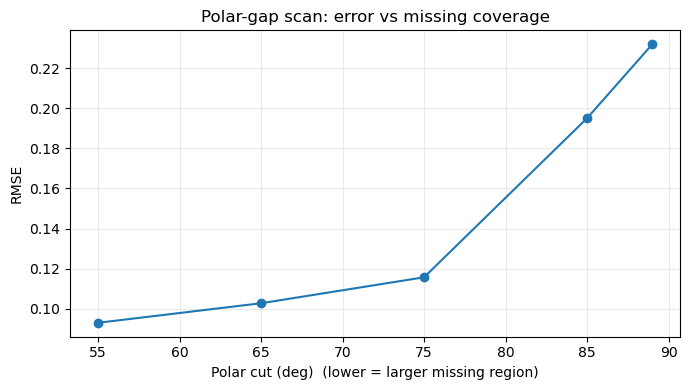

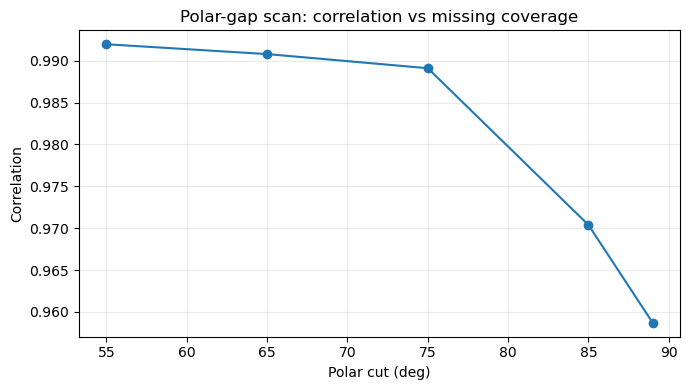

In [7]:

cuts = [55, 65, 75, 85, 89]
rmse_list, corr_list = [], []

for cut in cuts:
    _, Blos_meas, proj = simulate_measurement(
        Br_true, lat_deg,
        noise_sigma=0.08,
        resolution_sigma_pix=2.0,
        polar_cut_deg=cut
    )
    Br_rec = naive_recover_radial(Blos_meas, proj, proj_floor=0.25)
    rmse_list.append(rmse(Br_rec, Br_true))
    corr_list.append(corr(Br_rec, Br_true))

plt.figure(figsize=(7,4))
plt.plot(cuts, rmse_list, marker="o")
plt.xlabel("Polar cut (deg)  (lower = larger missing region)")
plt.ylabel("RMSE")
plt.title("Polar-gap scan: error vs missing coverage")
nice_plot()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(cuts, corr_list, marker="o")
plt.xlabel("Polar cut (deg)")
plt.ylabel("Correlation")
plt.title("Polar-gap scan: correlation vs missing coverage")
nice_plot()
plt.show()



## 7) Mini-challenge (15–25 minutes): design your “best instrument”

You control:
- noise_sigma
- resolution_sigma_pix
- polar_cut_deg
- observer geometry (equatorial or pole_on)

**Goal:** Minimize RMSE while keeping parameters realistic.

**Deliverable:** Report your best settings + one plot + RMSE & correlation.


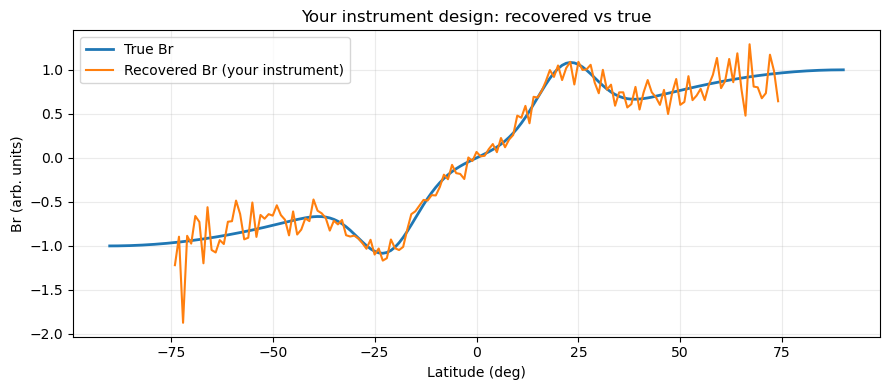

Your instrument metrics:
  RMSE = 0.1545922645215785
  Corr = 0.9804613872501536


In [8]:

# Try your own settings here!
noise_sigma = 0.08
resolution_sigma_pix = 1.5
polar_cut_deg = 75
observer = "equatorial"  # or "pole_on"

_, Blos_meas, proj = simulate_measurement(
    Br_true, lat_deg,
    noise_sigma=noise_sigma,
    resolution_sigma_pix=resolution_sigma_pix,
    polar_cut_deg=polar_cut_deg,
    observer=observer
)
Br_rec = naive_recover_radial(Blos_meas, proj, proj_floor=0.25)

plt.figure(figsize=(9,4))
plt.plot(lat_deg, Br_true, label="True Br", linewidth=2)
plt.plot(lat_deg, Br_rec, label="Recovered Br (your instrument)")
plt.xlabel("Latitude (deg)")
plt.ylabel("Br (arb. units)")
plt.title("Your instrument design: recovered vs true")
plt.legend()
nice_plot()
plt.show()

print("Your instrument metrics:")
print("  RMSE =", rmse(Br_rec, Br_true))
print("  Corr =", corr(Br_rec, Br_true))



## 8) Wrap-up (key takeaways)

- **Projection** turns a physical field into what the instrument can see (geometry matters).
- **Noise** increases uncertainty and can hide weak signals.
- **Resolution** removes small-scale structure first (smoothing biases interpretation).
- **Coverage gaps** can bias global conclusions, especially when poles matter.
- Simple simulations are powerful for understanding *what a dataset can and cannot tell you*.
